# Importing Packages

In [1]:
!apt-get install ncbi-blast+ -y
!pip install biopython pandas fsspec huggingface_hub

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  ncbi-data
The following NEW packages will be installed:
  ncbi-blast+ ncbi-data
0 upgraded, 2 newly installed, 0 to remove and 34 not upgraded.
Need to get 15.8 MB of archives.
After this operation, 71.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 ncbi-data all 6.1.20170106+dfsg1-9 [3,519 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 ncbi-blast+ amd64 2.12.0+ds-3build1 [12.3 MB]
Fetched 15.8 MB in 2s (8,646 kB/s)
Selecting previously unselected package ncbi-data.
(Reading database ... 126102 files and directories currently installed.)
Preparing to unpack .../ncbi-data_6.1.20170106+dfsg1-9_all.deb ...
Unpacking ncbi-data (6.1.20170106+dfsg1-9) ...
Selecting previously unselected package ncbi-blast+.
Preparing to unpack .../ncbi-blast+_2.12.0+ds-3build1_amd64.deb 

In [2]:
import pandas as pd
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import SeqIO
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Loading Datasets

In [3]:
bac_arch_df = pd.read_parquet("hf://datasets/tattabio/bac_arch_bigene/data/train-00000-of-00001.parquet")
modac_df = pd.read_parquet("hf://datasets/tattabio/modac_paralogy_bigene/data/train-00000-of-00001.parquet")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
print(bac_arch_df)

                                                  Name Seq1_accession  \
0    2,3-bisphosphoglycerate-independent phosphogly...    NP_418069.1   
1    2-amino-4-hydroxy-6-hydroxymethyldihydropterid...    NP_414684.1   
2        3,4-dihydroxy-2-butanone-4-phosphate synthase    NP_417513.1   
3                            3-dehydroquinate synthase    NP_417848.1   
4     3-methyl-2-oxobutanoate hydroxymethyltransferase    NP_414676.1   
..                                                 ...            ...   
260    cyclic pyranopterin monophosphate synthase MoaC    NP_415304.1   
261  uroporphyrinogen-III C-methyltransferase / sir...    NP_417827.1   
262  thioredoxin-disulfide reductase / thioredoxin ...    NP_415408.1   
263                           dihydropteroate synthase    NP_417644.4   
264  tRNA-2-methylthio-N(6)-dimethylallyladenosine ...    NP_415194.1   

     Seq2_accession                                               Seq1  \
0    WP_011277706.1  MLVSKKPMVLVILDGYGYREEQQDNAIF

In [ ]:
print(modac_df)

         ID1                                               Seq1     ID2  \
0     E0I7Z3  MSDTNSIIRFERVTKRYDNGSPVLSDVSFEIERGKFYTLLGPSGCG...  E0I7Z2   
1     D9PZK5  MILNAGMLSSGGVDMEYIRLEDVWKTYRTKNVTATPLRGLNMNVDK...  D9PZK6   
2     C4LAU3  MLLAEKLQTRRQGRLFEFSLQLQPGEIGLLLGRSGSGKSTLLEMLA...  C4LAU4   
3     C4LAH6  MNAIEIHNLQCGYQEQAILQNVSFVLEERKILALLGPSGCGKTTLL...  C4LAH7   
4     C4L8Q6  MHDIEIRLCWSRSEFQLDVALQLPGQGVSALFGPSGCGKTTCLRAI...  C4L8Q7   
...      ...                                                ...     ...   
1487  Q1LU07  MSITIENVSKFFDNTQVLNNISLDINSGQMVALLGPSGSGKTTLLR...  Q1LU08   
1488  C7MHE4  MNSVDLENVTKIYSGSTPSVDDVSLTVGDGEFFTLLGPSGCGKSTT...  C7MHE5   
1489  C7MHQ3  MITFDDITVRFGQFTALPSLSLNIDEGEFFTLLGPSGCGKSTALRT...  C7MHQ2   
1490  Q2CC48  MTELSLRGLTKRFGNHTAVDDVTLDVPDGSFICLLGPSGCGKTTLL...  Q2CC47   
1491  Q2CJ49  MASVEISGLRKLYADVVALEDINLSIPTGSFYTLLGPSGCGKTTLL...  Q2CJ48   

                                                   Seq2  
0     MPSRTRLRMSDKSRNWYLIPYTAWIVLFVVAPIAL

#Experiments for Bac_Arch Datasets


In [4]:
# Save E. coli (queries)
ecoli_records = [SeqRecord(Seq(seq), id=str(acc), description="") for acc, seq in zip(bac_arch_df["Seq1_accession"], bac_arch_df["Seq1"])]
SeqIO.write(ecoli_records, "ecoli.faa", "fasta")

# Save Sulfolobus (corpus/db)
sulfolobus_records = [SeqRecord(Seq(seq), id=str(acc), description="") for acc, seq in zip(bac_arch_df["Seq2_accession"], bac_arch_df["Seq2"])]
SeqIO.write(sulfolobus_records, "sulfolobus.faa", "fasta")


265

##BLAST Implementation

## Hyperparameter Analysis (e-value)

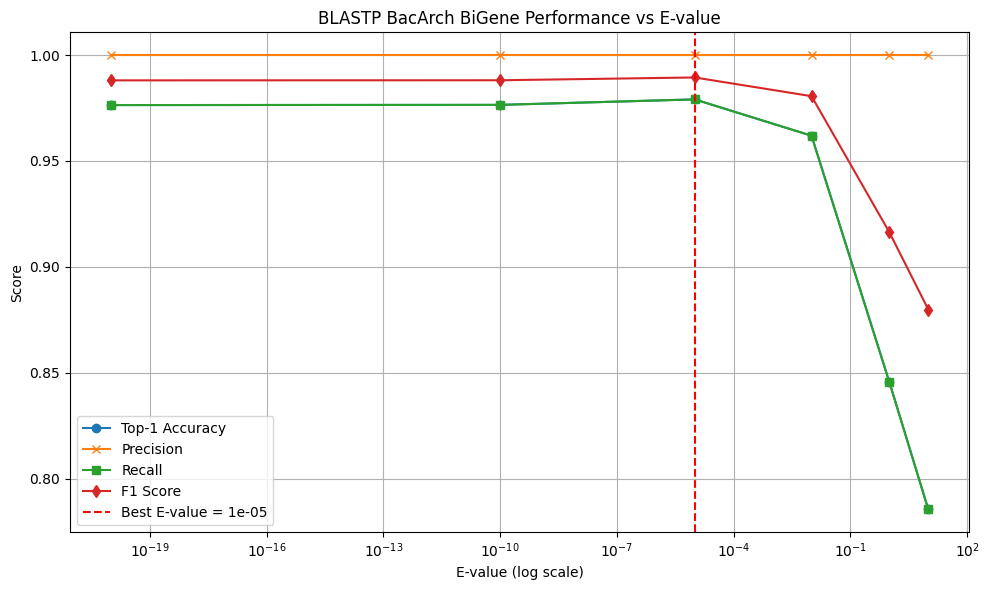

In [8]:
evalues = [1e-20, 1e-10, 1e-5, 1e-2, 1, 10]
results = []
true_pairs = dict(zip(bac_arch_df["Seq1_accession"], bac_arch_df["Seq2_accession"]))

all_blast_dfs = {}

for evalue in evalues:
    !blastp -query ecoli.faa -db sulfolobus_db -out blast_results_tmp.tsv -evalue {evalue} -outfmt 6 -max_target_seqs 1
    cols = ["query_id", "subject_id", "pident", "length", "mismatches", "gapopens",
            "qstart", "qend", "sstart", "send", "evalue", "bitscore"]
    blast_df = pd.read_csv("blast_results_tmp.tsv", sep="\t", names=cols)

    blast_df["is_correct"] = blast_df.apply(lambda row: row["subject_id"] == true_pairs.get(row["query_id"]), axis=1)
    all_blast_dfs[evalue] = blast_df.copy()
    y_bin_true = [1] * len(blast_df)
    y_bin_pred = blast_df["is_correct"].astype(int).tolist()

    precision = precision_score(y_bin_true, y_bin_pred, zero_division=0)
    recall = recall_score(y_bin_true, y_bin_pred, zero_division=0)
    f1 = f1_score(y_bin_true, y_bin_pred, zero_division=0)
    top1_acc = blast_df["is_correct"].mean()

    results.append({
        "evalue": evalue,
        "top1_accuracy": top1_acc,
        "precision": precision,
        "recall": recall,
        "f1_score": f1
    })


results_df = pd.DataFrame(results)

best_row = results_df.loc[results_df["f1_score"].idxmax()]
best_evalue = best_row["evalue"]

plt.figure(figsize=(10, 6))
plt.plot(results_df["evalue"], results_df["top1_accuracy"], marker='o', label="Top-1 Accuracy")
plt.plot(results_df["evalue"], results_df["precision"], marker='x', label="Precision")
plt.plot(results_df["evalue"], results_df["recall"], marker='s', label="Recall")
plt.plot(results_df["evalue"], results_df["f1_score"], marker='d', label="F1 Score")
plt.axvline(x=best_evalue, color='red', linestyle='--', label=f'Best E-value = {best_evalue:.0e}')
plt.xscale('log')
plt.xlabel('E-value (log scale)')
plt.ylabel('Score')
plt.title('BLASTP BacArch BiGene Performance vs E-value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [5]:
!makeblastdb -in sulfolobus.faa -dbtype prot -out sulfolobus_db

!blastp -query ecoli.faa -db sulfolobus_db -out blast_results.tsv -evalue 1e-5 -outfmt 6 -max_target_seqs 1




Building a new DB, current time: 05/07/2025 15:36:57
New DB name:   /content/sulfolobus_db
New DB title:  sulfolobus.faa
Sequence type: Protein
Keep MBits: T
Maximum file size: 1000000000B
Adding sequences from FASTA; added 265 sequences in 0.00697398 seconds.




In [6]:
cols = ["query_id", "subject_id", "pident", "length", "mismatches", "gapopens",
        "qstart", "qend", "sstart", "send", "evalue", "bitscore"]
blast_df = pd.read_csv("blast_results.tsv", sep="\t", names=cols)

true_pairs = dict(zip(bac_arch_df["Seq1_accession"], bac_arch_df["Seq2_accession"]))
blast_df["is_correct"] = blast_df.apply(lambda row: row["subject_id"] == true_pairs.get(row["query_id"]), axis=1)

# Accuracy
accuracy = blast_df["is_correct"].mean()
print(f"BLASTP Top-1 Accuracy: {accuracy:.3f}")


BLASTP Top-1 Accuracy: 0.979


## Evaluation Metrics

In [7]:
true_pairs = dict(zip(bac_arch_df["Seq1_accession"], bac_arch_df["Seq2_accession"]))

# Top-1 match evaluation
blast_df["is_correct"] = blast_df.apply(lambda row: row["subject_id"] == true_pairs.get(row["query_id"]), axis=1)

# Precision, Recall, F1 on top-1
y_true = [true_pairs[qid] for qid in blast_df["query_id"] if qid in true_pairs]
y_pred = blast_df["subject_id"].tolist()

y_bin_true = [1] * len(y_true)
y_bin_pred = blast_df["is_correct"].astype(int).tolist()

precision = precision_score(y_bin_true, y_bin_pred)
recall = recall_score(y_bin_true, y_bin_pred)
f1 = f1_score(y_bin_true, y_bin_pred)
top1_acc = blast_df["is_correct"].mean()

print(f"Top-1 Accuracy : {top1_acc:.3f}")
print(f"Precision       : {precision:.3f}")
print(f"Recall          : {recall:.3f}")
print(f"F1 Score        : {f1:.3f}")


Top-1 Accuracy : 0.979
Precision       : 1.000
Recall          : 0.979
F1 Score        : 0.989


Confusion Matrix

True Label Counts: Counter({1: 191})
Predicted Label Counts: Counter({1: 187, 0: 4})


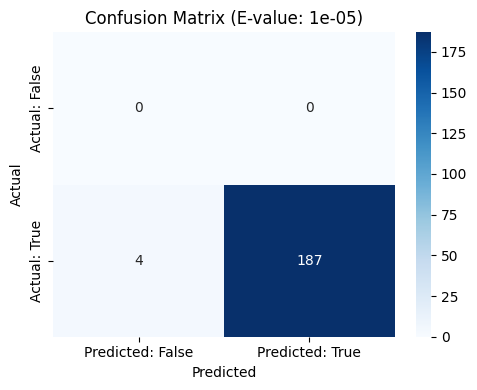

In [9]:
best_blast_df = all_blast_dfs[best_evalue]

y_bin_true = []
y_bin_pred = []

for _, row in best_blast_df.iterrows():
    query = row["query_id"]
    subject = row["subject_id"]

    true_label = 1 if query in true_pairs else 0
    y_bin_true.append(true_label)

    pred_label = 1 if true_pairs.get(query) == subject else 0
    y_bin_pred.append(pred_label)
from collections import Counter

print("True Label Counts:", Counter(y_bin_true))
print("Predicted Label Counts:", Counter(y_bin_pred))
conf_matrix = confusion_matrix(y_bin_true, y_bin_pred)

# Plot confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted: False', 'Predicted: True'],
            yticklabels=['Actual: False', 'Actual: True'])
plt.title(f'Confusion Matrix (E-value: {best_evalue:.0e})')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()


# Experiments for ModAC Paralog AC

In [9]:
import pandas as pd
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import SeqIO

modA_records = [SeqRecord(Seq(seq), id=str(acc), description="") for acc, seq in zip(modac_df["ID1"], modac_df["Seq1"])]
SeqIO.write(modA_records, "modA.faa", "fasta")
modC_records = [SeqRecord(Seq(seq), id=str(acc), description="") for acc, seq in zip(modac_df["ID2"], modac_df["Seq2"])]
SeqIO.write(modC_records, "modC.faa", "fasta")


1492

## BLAST Implementation

In [ ]:
# Create BLAST database for ModC proteins
!makeblastdb -in modC.faa -dbtype prot -out modC_db

# ModA (queries) vs ModC (database)
!blastp -query modA.faa -db modC_db -out modac_blast_top1.tsv -evalue 1e-5 -outfmt 6 -max_target_seqs 1




Building a new DB, current time: 05/07/2025 05:03:50
New DB name:   /content/modC_db
New DB title:  modC.faa
Sequence type: Protein
Keep MBits: T
Maximum file size: 1000000000B
Adding sequences from FASTA; added 1492 sequences in 0.0395591 seconds.




## Evaluation Metrics

In [11]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Load BLASTP output
cols = ["query_id", "subject_id", "pident", "length", "mismatches", "gapopens",
        "qstart", "qend", "sstart", "send", "evalue", "bitscore"]
blast_df = pd.read_csv("modac_blast_top1.tsv", sep="\t", names=cols)

true_pairs = dict(zip(modac_df["ID1"], modac_df["ID2"]))

blast_df["is_correct"] = blast_df.apply(lambda row: row["subject_id"] == true_pairs.get(row["query_id"]), axis=1)
# Compute metrics
y_true_bin = [1] * len(blast_df)
y_pred_bin = blast_df["is_correct"].astype(int).tolist()

precision = precision_score(y_true_bin, y_pred_bin)
recall = recall_score(y_true_bin, y_pred_bin)
f1 = f1_score(y_true_bin, y_pred_bin)
top1_acc = blast_df["is_correct"].mean()

print(f"Top-1 Accuracy : {top1_acc:.3f}")
print(f"Precision       : {precision:.3f}")
print(f"Recall          : {recall:.3f}")
print(f"F1 Score        : {f1:.3f}")


Top-1 Accuracy : 0.001
Precision       : 1.000
Recall          : 0.001
F1 Score        : 0.003


#Hyperparameter Analysis (e-value)

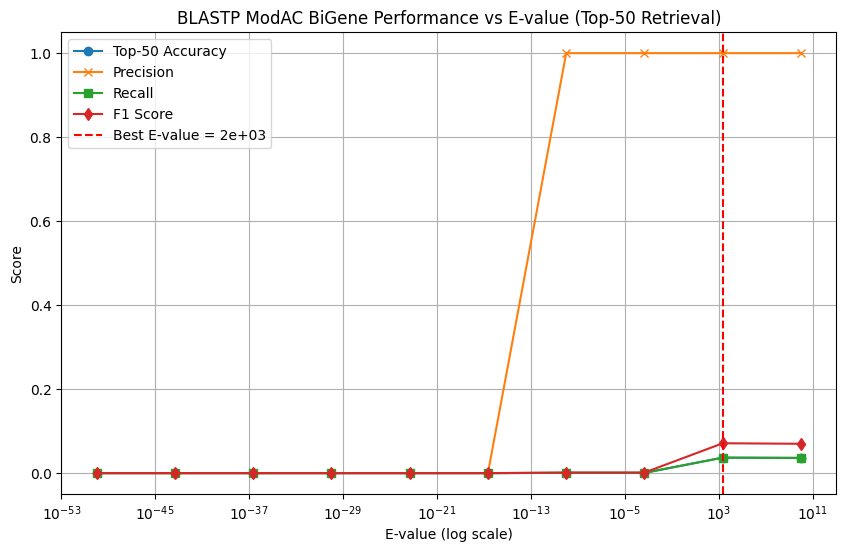

In [18]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

import numpy as np

evalues_m = np.logspace(-50, 10, num=10)
results_m = []
all_blast_dfs_m={}
true_pairs = dict(zip(modac_df["ID1"], modac_df["ID2"]))

for evalue in evalues_m:
    !blastp -query modA.faa -db modC_db -out modac_blast_top50.tsv -evalue {evalue} -outfmt 6 -max_target_seqs 50

    # Load BLAST output
    cols = ["query_id", "subject_id", "pident", "length", "mismatches", "gapopens",
            "qstart", "qend", "sstart", "send", "evalue", "bitscore"]
    blast_df = pd.read_csv("modac_blast_top50.tsv", sep="\t", names=cols)
    all_blast_dfs_m[evalue] = blast_df.copy()

    # Group subject_ids per query (top-50)
    grouped = blast_df.groupby("query_id")["subject_id"].apply(list).to_dict()
    y_bin_true = []
    y_bin_pred = []

    for query_id, true_subject in true_pairs.items():
        y_bin_true.append(1)
        preds = grouped.get(query_id, [])
        if true_subject in preds:
            y_bin_pred.append(1)
        else:
            y_bin_pred.append(0)

    # Metrics
    precision = precision_score(y_bin_true, y_bin_pred, zero_division=0)
    recall = recall_score(y_bin_true, y_bin_pred, zero_division=0)
    f1 = f1_score(y_bin_true, y_bin_pred, zero_division=0)
    topk_acc = sum(y_bin_pred) / len(y_bin_pred)

    results_m.append({
        "evalue": evalue,
        "topk_accuracy": topk_acc,
        "precision": precision,
        "recall": recall,
        "f1_score": f1
    })

mresults_df = pd.DataFrame(results_m)
# Find best e-value
best_row = mresults_df.loc[mresults_df["f1_score"].idxmax()]
best_evalue_m = best_row["evalue"]

plt.figure(figsize=(10, 6))
plt.plot(mresults_df["evalue"], mresults_df["topk_accuracy"], marker='o', label="Top-50 Accuracy")
plt.plot(mresults_df["evalue"], mresults_df["precision"], marker='x', label="Precision")
plt.plot(mresults_df["evalue"], mresults_df["recall"], marker='s', label="Recall")
plt.plot(mresults_df["evalue"], mresults_df["f1_score"], marker='d', label="F1 Score")
plt.axvline(x=best_evalue_m, color='red', linestyle='--', label=f'Best E-value = {best_evalue_m:.0e}')
plt.xscale('log')
plt.xlabel('E-value (log scale)')
plt.ylabel('Score')
plt.title('BLASTP ModAC BiGene Performance vs E-value (Top-50 Retrieval)')
plt.legend()
plt.grid(True)
plt.show()


Metrics


In [19]:
best_row_m = mresults_df.loc[mresults_df["recall"].idxmax()]
print("Best setting based on recall:")
print(best_row_m)

Best setting based on recall:
evalue           2154.434690
topk_accuracy       0.036863
precision           1.000000
recall              0.036863
f1_score            0.071105
Name: 8, dtype: float64


Confusion Matrix

True Label Counts: Counter({1: 1492})
Predicted Label Counts: Counter({0: 1438, 1: 54})


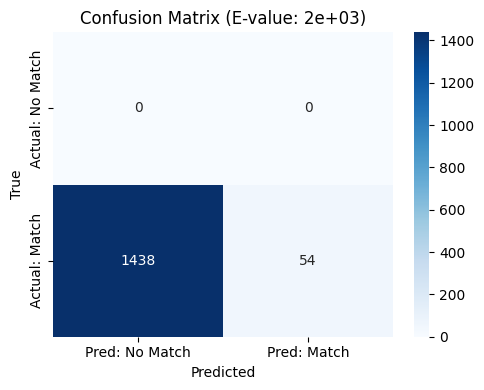

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix
conf_matrix = confusion_matrix(y_bin_true, y_bin_pred)

from collections import Counter
print("True Label Counts:", Counter(y_bin_true))
print("Predicted Label Counts:", Counter(y_bin_pred))
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred: No Match', 'Pred: Match'],
            yticklabels=['Actual: No Match', 'Actual: Match'])
plt.title(f'Confusion Matrix (E-value: {best_evalue_m:.0e})')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()